In [1]:
# from google.colab import drive
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from keras.layers import *
from keras.models import *
from sklearn.preprocessing import MinMaxScaler
import pickle
from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/MyDrive/Traffic_data'

Mounted at /content/drive


In [2]:
#  import torch
# seed = 1024
# nrows = 150159

# how many vehicles?
nrows = 100000
feature_names = ['ego_x',"ego_v", 'f_dx', 'f_dy', 'f_dv', 'b_dx', 'b_dy','b_dv', 'l_dx', 'l_dy', 'l_dv', 'r_dx', 'r_dy', 'r_dv']
# Label1: Ego vehicle lateral displacement
label_names_1 = ['ego_x']

# Label2: Ego vehicle longitudinal velocity
label_names_2 = ['ego_v']
# label_name = 'ego_v'
time_columns = "index"

full_path = Path+'/Final_result.xlsx' 

###############################
# nrows = 150158+1
################################

train_rows=int(nrows*0.7) 
epoch_no = 200
batch_size_RNN = 128
n_in = 10
n_out = 6

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from sklearn.preprocessing import MinMaxScaler
import h5py
df = pd.read_excel(full_path,parse_dates=[time_columns],nrows=nrows)
df = df.sort_values(time_columns)
df.index = np.arange(df.shape[0])
df2=df.iloc[0:nrows,:]
df2[:5]

,index,ego_x,ego_v,f_dx,f_dy,f_dv,b_dx,b_dy,b_dv,l_dx,l_dy,l_dv,r_dx,r_dy,r_dv
0,0,51.816071,34.006429,30.0,300.0,0.0,0.561490,0.561490,2.236814,-13.171722,-13.171722,0.154693,30.000000,300.000000,0.000000
1,1,52.726857,35.324286,30.0,300.0,0.0,-1.311634,-1.311634,-0.999323,-13.838332,-13.838332,-0.283392,30.000000,300.000000,0.000000
2,2,53.001810,37.491429,30.0,300.0,0.0,-2.030706,-2.030706,-4.150722,-13.980892,-13.980892,-2.208976,30.000000,300.000000,0.000000
3,3,56.291381,39.865238,30.0,300.0,0.0,-5.374435,-5.374435,-6.864538,-17.218590,-17.218590,-4.814726,30.000000,300.000000,0.000000
4,4,29.079835,33.970674,30.0,300.0,0.0,1.012832,1.012832,2.269220,-10.292661,-10.292661,4.718274,9.564515,9.564515,0.190448


## **Trial**

<function matplotlib.pyplot.show>

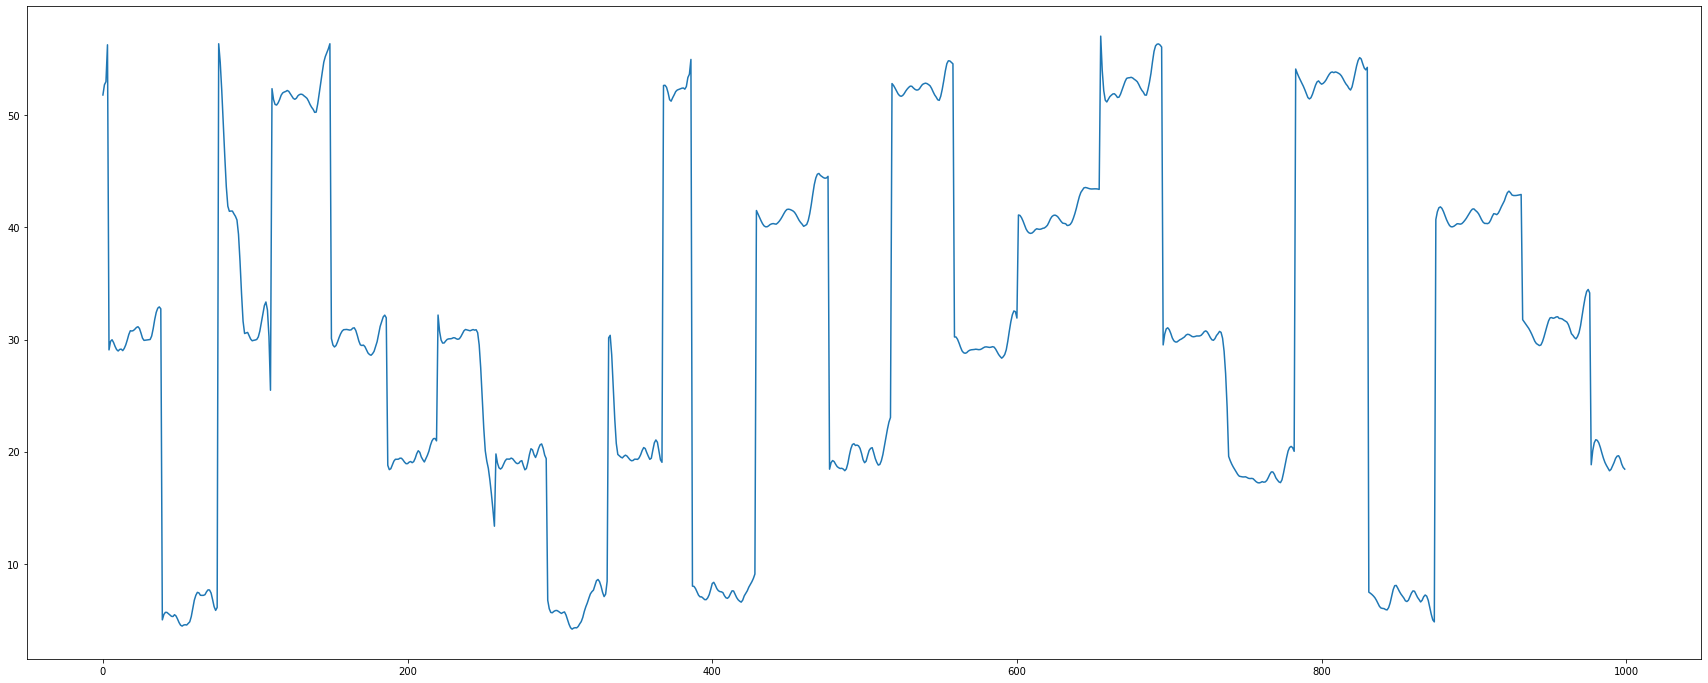

In [4]:
from time import thread_time
from numpy.core.numeric import NaN
e = df2.get(label_names_1)
e = e.values.tolist()
# exam = []
# for m in e:
#   exam.append(m[0])
# # print(exam)
# # print(((exam)))
# # plt.figure(figsize=(80, 12))  
# # plt.plot(exam)
# # plt.legend(loc='best', fontsize='12')
# # plt.xticks(fontsize=12)
# # plt.yticks(fontsize=12)
# # plt.title('Lateral Position Prediction w/ Train dataset (5s Forecast)', fontsize='16')
# # plt.xlabel('Time (s)', fontsize='14')
# # plt.ylabel('Relative Lateral Position (m)', fontsize='14')
# # plt.show
# # print(len(exam))

# copy = exam.copy()
# bad_index = []
# threshold = 3
# for i in range(len(exam)-1):
#   now = exam[i]
#   nxt = exam[i+1]
#   if abs(nxt - now) >= threshold:
#     for j in range(i+1, len(exam)):
#         copy[j] -= nxt-now
# # idx = 0
# # while idx != len(exam)-n_out-n_out:
# #   # print(idx)
# #   # print(abs(idx-(len(exam)-n_out-n_out)))
# #   # sum = 0
# #   check = False
# #   for j in exam[idx:idx+n_out-1]:
# #     if abs(exam[idx] - exam[idx+1]) >= threshold:
# #       check = True
# #       idx += n_out
# #       break
# #   if check == False:
# #     dis = np.average(exam[idx:idx+n_out-1])
# #     print(dis)
# #     for k in range(idx, idx+n_out):
# #       copy[k] -= dis
# #     idx += 1



# clean = [x for x in copy if x != -1000]
# cln = []
# for i in clean:
#   cln.append(i[0])
# print(cln)
# clean = [x%10 for x in copy]
plt.figure(figsize=(30, 12))  
plt.plot(e[:1000])
plt.show

## **LSTM**

In [5]:
# #Normalization
# scaler_y_1 = MinMaxScaler(feature_range=(-1, 1))
# scaler_y_1.fit(df2[label_names_1].values.astype(float))

# scaler_y_2 = MinMaxScaler(feature_range=(-1, 1))
# scaler_y_2.fit(df2[label_names_2].values.astype(float))

# scaler_x = MinMaxScaler(feature_range=(-1, 1))
# scaler_x.fit(df2[feature_names].values.astype(float))

In [6]:
## Create dataset
# scaler_x_ls = []
# scaler_y_1_ls = []
# scaler_y_2_ls = []
# scaler_x_ls = []
# scaler_y1_ls = []
scaler_ls = []
scaler_x_ls = []
scaler_v_ls = []
def create_dataset(df,feature_names,label_names_1,label_names_2,n_in,n_out):
  X, Y1, Y2 = [], [], []
  for i in tqdm(range(df.shape[0]-n_in-n_out+1)):
    check = df[label_names_1].values[i:i+n_in+n_out].astype(float)
    #####################################################################
    jump = False
    for j in range(n_in+n_out-1):
      if abs(check[j] - check[j+1]) > 3.6:
        jump = True
        break
    if jump == True:
      continue
    #####################################################################
    # x = df[feature_names].values[i:i+n_in].astype(float)
    # label1 = df[label_names_1].values[i+n_in:i+n_in+n_out].astype(float)
    # label2 = df[label_names_2].values[i+n_in:i+n_in+n_out].astype(float)
    # #Normalization
    # scaler_x = MinMaxScaler(feature_range=(-1, 1))
    # scaler_x.fit(df[label_names_1].values[i:i+n_in].astype(float))
    # scaler_x_ls.append(scaler_x)

    # scaler_y_1 = MinMaxScaler(feature_range=(-1, 1))
    # scaler_y_1.fit(label1)
    # scaler_y_1_ls.append(scaler_y_1)

    # scaler_y_2 = MinMaxScaler(feature_range=(-1, 1))
    # scaler_y_2.fit(label2)
    # scaler_y_2_ls.append(scaler_y_2)


    # x = df[feature_names].values[i:i+n_in].astype(float)
    # label1 = df[label_names_1].values[i+n_in:i+n_in+n_out].astype(float)
    # label2 = df[label_names_2].values[i+n_in:i+n_in+n_out].astype(float)
    #Normalization
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(df[feature_names].values[i:i+n_in+n_out].astype(float))
    scaler_ls.append(scaler)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    scaler_x.fit(df[label_names_1].values[i:i+n_in+n_out].astype(float))
    scaler_x_ls.append(scaler_x)

    scaler_v = MinMaxScaler(feature_range=(-1, 1))
    scaler_v.fit(df[label_names_2].values[i:i+n_in+n_out].astype(float))
    scaler_v_ls.append(scaler_v)

    # scaler_y_1 = MinMaxScaler(feature_range=(-1, 1))
    # scaler_y_1.fit(label1)
    # scaler_y_1_ls.append(scaler_y_1)

    # scaler_y_2 = MinMaxScaler(feature_range=(-1, 1))
    # scaler_y_2.fit(label2)
    # scaler_y_2_ls.append(scaler_y_2)
    #####################################################################
    batch = df[feature_names].values[i:i+n_in+n_out].astype(float)
    batch = scaler.transform(batch)

    label1 = df[label_names_1].values[i:i+n_in+n_out].astype(float)
    label1 = scaler_x.transform(label1)

    label2 = df[label_names_2].values[i:i+n_in+n_out].astype(float)
    label2 = scaler_v.transform(label2)

    x  = batch[:n_in]
    label1 = label1[n_in:n_in+n_out]
    label2 = label2[n_in:n_in+n_out]
    # print((batch))
    # print(("\n"))
    # return 0
    # x = df[feature_names].values[i:i+n_in+n_out].astype(float)
    # label1 = df[label_names_1].values[i:i+n_in+n_out].astype(float)
    # label2 = df[label_names_2].values[i:i+n_in+n_out].astype(float)
    # x = scaler.transform(x)[:n_in]
    # label1 = scaler.transform(label1)[n_in:n_in+n_out]
    # label2 = scaler.transform(label2)[n_in:n_in+n_out]
    # label1 = scaler.transform(label1)
    # label2 = scaler.transform(label2)
    # x = batch
    #####################################################################
    X.append(x)
    Y1.append(label1)
    Y2.append(label2)
  return np.array(X),np.array(Y1),np.array(Y2)

In [7]:
X_1,Y1,Y2 = create_dataset(df2,feature_names,label_names_1,label_names_2,n_in,n_out)

100%|██████████| 99985/99985 [15:47<00:00, 105.49it/s]


In [8]:
x1_train, x1_test = X_1[:int(len(X_1)*0.8)], X_1[int(len(X_1)*0.8):]
y1_train, y1_test = Y1[:int(len(Y1)*0.8)], Y1[int(len(Y1)*0.8):]
y2_train, y2_test = Y2[:int(len(Y2)*0.8)], Y2[int(len(Y2)*0.8):]
print(x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape,y2_train.shape,y2_test.shape)

(65365, 10, 14) (16342, 10, 14) (65365, 6, 1) (16342, 6, 1) (65365, 6, 1) (16342, 6, 1)


In [ ]:
# out=5,y1 ae-lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector,TimeDistributed
y1_train=y1_train.reshape((y1_train.shape[0],y1_train.shape[1]))
# Initialising the RNN
regressor_x = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=100
regressor_x.add(Bidirectional(LSTM(units = layer_1_units, input_shape = (x1_train.shape[1], x1_train.shape[2]))))
regressor_x.add(RepeatVector(n_out))
regressor_x.add(Bidirectional(LSTM(layer_1_units, activation='relu', return_sequences=True)))
regressor_x.add(TimeDistributed(Dense(1)))

# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor_x.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# epoch_no=20
# batch_size_RNN=64
model_x = regressor_x.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/200
511/511 [==============================] - 46s 76ms/step - loss: 0.1081
Epoch 2/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0691
Epoch 3/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0599
Epoch 4/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0549
Epoch 5/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0512
Epoch 6/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0481
Epoch 7/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0463
Epoch 8/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0439
Epoch 9/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0421
Epoch 10/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0405
Epoch 11/200
511/511 [==============================] - 39s 76ms/step - loss: 0.0382
Epoch 12/200
511/511 [==============================] - 39s 76ms/step - lo

In [ ]:
# out=10,y2 ae-lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector,TimeDistributed
y2_train=y2_train.reshape((y2_train.shape[0],y2_train.shape[1]))
# Initialising the RNN
regressor_v = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=100
regressor_v.add(Bidirectional(LSTM(units = layer_1_units, input_shape = (x1_train.shape[1], x1_train.shape[2]))))
regressor_v.add(RepeatVector(n_out))
regressor_v.add(Bidirectional(LSTM(layer_1_units, activation='relu', return_sequences=True)))
regressor_v.add(TimeDistributed(Dense(1)))

# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor_v.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# epoch_no=20
# batch_size_RNN=64
model_v = regressor_v.fit(x1_train, y2_train, epochs = epoch_no, batch_size = batch_size_RNN)

In [ ]:
trainPredict_x = regressor_x.predict(x1_train)
trainPredict_v = regressor_v.predict(x1_train)

trainPredict_x = trainPredict_x.reshape(trainPredict_x.shape[0],trainPredict_x.shape[1])
trainPredict_v = trainPredict_v.reshape(trainPredict_v.shape[0],trainPredict_v.shape[1])

# y1_train_cnt =  scaler_y_1.inverse_transform(y1_train.reshape(-1, n_out))
# y2_train_cnt =  scaler_y_2.inverse_transform(y2_train.reshape(-1, n_out))

# trainPredict_x_cnt = scaler_y_1.inverse_transform(trainPredict_x)
# trainPredict_v_cnt = scaler_y_2.inverse_transform(trainPredict_v)

In [ ]:
test_len = len(scaler_x_ls[np.shape(trainPredict_x)[0]:])

y1_test_cnt = np.empty([len(scaler_x_ls[np.shape(trainPredict_x)[0]:]), n_out])
y2_test_cnt = np.empty([len(scaler_v_ls[np.shape(trainPredict_x)[0]:]), n_out])

testPredict_x_cnt = np.empty([len(scaler_x_ls[np.shape(trainPredict_x)[0]:]), n_out])
testPredict_v_cnt = np.empty([len(scaler_v_ls[np.shape(trainPredict_x)[0]:]), n_out])

testPredict_x = regressor_x.predict(x1_test)
testPredict_v = regressor_v.predict(x1_test)
testPredict_x = testPredict_x.reshape(testPredict_x.shape[0],testPredict_x.shape[1])
testPredict_v = testPredict_v.reshape(testPredict_v.shape[0],testPredict_v.shape[1])

for i in range(len(scaler_x_ls[np.shape(trainPredict_x)[0]:])):
  y1_test_cnt[i] = scaler_x_ls[i + test_len].inverse_transform(y1_test.reshape(-1, n_out)[i].reshape(-1, 1)).reshape(1,-1)
  y2_test_cnt[i] = scaler_v_ls[i + test_len].inverse_transform(y2_test.reshape(-1, n_out)[i].reshape(-1, 1)).reshape(1,-1)
  testPredict_x_cnt[i] = scaler_x_ls[i + test_len].inverse_transform(testPredict_x[i].reshape(-1, 1)).reshape(1,-1)
  testPredict_v_cnt[i] = scaler_v_ls[i + test_len].inverse_transform(testPredict_v[i].reshape(-1, 1)).reshape(1,-1)

In [ ]:
# testPredict_x = regressor_x.predict(x1_test)
# testPredict_v = regressor_v.predict(x1_test)

# testPredict_x = testPredict_x.reshape(testPredict_x.shape[0],testPredict_x.shape[1])
# testPredict_v = testPredict_v.reshape(testPredict_v.shape[0],testPredict_v.shape[1])

# y1_test_cnt =  scaler_y_1.inverse_transform(y1_test.reshape(-1, n_out))
# y2_test_cnt =  scaler_y_2.inverse_transform(y2_test.reshape(-1, n_out))

# testPredict_x_cnt = scaler_y_1.inverse_transform(testPredict_x)
# testPredict_v_cnt = scaler_y_2.inverse_transform(testPredict_v)

# **Train**

In [ ]:
start = 0
end = 2000
duration = end - start + 1
plt.figure(figsize=(20, 12))  
plt.plot(range(1,duration),y1_train_cnt[start:end,0]/3.28084,'green',label='GT',linewidth = 3, alpha=0.6)
plt.plot(range(n_out+1,duration + n_out),trainPredict_x_cnt[start:end,n_out-1]/3.28084,'blue',label='Prediction at 5s',linewidth = 3, alpha=0.3)
# m = 1
# for i in range(start,end,2):
#   traj = np.insert(trainPredict_x_cnt[i][:n_out], 0, y1_train_cnt[start:end,0][m-1], axis=0)
#   plt.plot(range(m,m+n_out+1),traj/3.28084,'gray', alpha=0.6)
#   m = m + 2
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Train dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

In [ ]:
plt.figure(figsize=(20, 12))  
plt.plot(range(1,duration),y2_train_cnt[start:end,0]*1.09728,'green',label='GT',linewidth = 3, alpha=0.6)
plt.plot(range(1+n_out,duration+n_out),trainPredict_v_cnt[start:end,n_out-1]*1.09728,'blue',label='Prediction at 5s',linewidth = 3, alpha=0.3)
# m = 1
# for i in range(start,end,2):
#   traj = np.insert(trainPredict_v_cnt[i][:], 0, y2_train_cnt[start:end,0][m-1], axis=0)
#   plt.plot(range(m,m+n_out+1),traj*1.09728,'gray', alpha=0.6)
#   m = m + 2
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Longitudinal Velocity Prediction w/ Train dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Longitudinal Velocity (km/h)', fontsize='14')
plt.show

# **Test**

In [ ]:
start = 4208
end = 4450

# start = 12000
# end = 12200


# start = 15994
# end = 16127
duration = end - start + 1
plt.figure(figsize=(20, 12))  
plt.plot(range(1,duration),y1_test_cnt[start:end,0]/3.28084,'green',label='Ground Truth',linewidth = 3, alpha=0.6)
# plt.plot(range(1+n_out,duration+n_out),testPredict_x_cnt[start:end,n_out-1]/3.28084,'blue',label='Prediction at ' +str(n_out)+'th-sec',linewidth = 3, alpha=0.2)
m = 1
for i in range(start,end,4):
  traj = np.insert(testPredict_x_cnt[i][:], 0, y1_test_cnt[start:end,0][m-1], axis=0)
  if m == 1:
    plt.plot(range(m,m+n_out+1),traj/3.28084,'gray', label='Trajectory Prediction',linewidth = 1.5, alpha=0.6)
  else:
    plt.plot(range(m,m+n_out+1),traj/3.28084,'gray', linewidth = 1.5, alpha=0.6)
  m = m + 4
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Lateral Position Prediction ("+ str(n_out) +"s forecast based on past " + str(n_in) + "s)", fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

In [ ]:
plt.figure(figsize=(20, 12))  
plt.plot(range(1,duration),y2_test_cnt[start:end,0]*1.09728/3.6,'green',label='GT',linewidth = 3, alpha=0.6)
# plt.plot(range(1+n_out,duration+n_out),testPredict_v_cnt[start:end,n_out-1]*1.09728,'blue',label='Prediction at ' +str(n_out)+'s',linewidth = 3, alpha=0.3)

m = 1
for i in range(start,end,4):
  traj = np.insert(testPredict_v_cnt[i][:], 0, y2_test_cnt[start:end,0][m-1], axis=0)
  if m == 1:
    plt.plot(range(m,m+n_out+1),traj*1.09728/3.6,'gray', label='Trajectory Prediction',linewidth = 1.5, alpha=0.6)
  else:
    plt.plot(range(m,m+n_out+1),traj*1.09728/3.6,'gray', linewidth = 1.5, alpha=0.6)
  m = m + 4
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Longitudinal Speed Prediction ("+ str(n_out) +"s forecast based on past " + str(n_in) + "s)", fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Longitudinal Speed (m/s)', fontsize='14')
plt.show

In [ ]:
regressor_x.save('model_x_10_10.h5')
regressor_v.save('model_v_10_10.h5')  

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_x = sqrt(mean_squared_error(y1_test_cnt[:,n_out-1]/3.28084, testPredict_x_cnt[:,n_out-1]/3.28084))
rms_v = sqrt(mean_squared_error(y2_test_cnt[:,n_out-1]*1.09728, testPredict_v_cnt[:,n_out-1]*1.09728))
print("Lateral position prediction RMSE at " + str(n_out) + "-th second is "+ str(np.around(rms_x, 2)) + " m")
print("Longitudinal speed prediction RMSE at " + str(n_out) + "-th second is "+ str(np.around(rms_v/3.6, 2)) + " m/s")

In [ ]:
rms_x_ls, rms_v_ls = [],[]
for i in range(0, n_out):
  rms_x_ls.append(sqrt(mean_squared_error(y1_test_cnt[:,i]/3.28084, testPredict_x_cnt[:,i]/3.28084)))
  rms_v_ls.append(sqrt(mean_squared_error(y2_test_cnt[:,i]*1.09728/3.6, testPredict_v_cnt[:,i]*1.09728/3.6)))

In [ ]:
plt.figure(figsize=(10, 5))  
plt.plot(range(1,n_out+1),rms_x_ls,'green',label='RMS Lateral Pos',linewidth = 3, alpha=0.6)
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('RMSE Trend for '+str(n_out)+" sec prediction based on past "+str(n_in)+" sec", fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('RMSE (m)', fontsize='14')
plt.show

In [ ]:
rms_x_ls

In [ ]:
plt.figure(figsize=(10, 5))  
plt.plot(range(1,n_out+1),rms_v_ls,'blue',label='RMS Longitudinal Spd',linewidth = 3, alpha=0.6)
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('RMS Trend for '+str(n_out)+" sec prediction based on past "+str(n_in)+" sec", fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('RMSE (m/s)', fontsize='14')
plt.show

In [ ]:
rms_v_ls

In [ ]:
result_x_paper = [0.46, 0.52, 0.61, 0.68]
result_x_10 = [0.19, 0.23, 0.24, 0.31]
# result_x_6 = [0.23, 0.35, 0.46, 0.57]
# result_x_4 = [0.24, 0.36, 0.46, 0.57]
t = [4, 6, 8, 10]
plt.figure(figsize=(12, 6))  
plt.plot(t,result_x_paper,'grey',label='ByPass LSTM (Ref.): Input = 10s',linewidth = 3, alpha=0.9)
plt.plot(t,result_x_10,'blue',label='AE-BiLSTM: Input = 10s',linewidth = 3, alpha=0.5)
# plt.plot(t,result_x_6,'magenta',label='AE-BiLSTM: Input = 6s',linewidth = 3, alpha=0.5)
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lane-changing (lateral position) prediction w/ different input sizes', fontsize='16')
plt.xlabel('Prediction at i-th second', fontsize='14')
plt.ylabel('RMS (m)', fontsize='14')
plt.show

In [ ]:
result_v_paper = [1.26, 1.76, 2.30, 2.78]
result_v_10 = [0.81, 1.46, 2.12, 2.74]
result_v_6 = [0.74, 1.39, 2.11, 2.71]
t = [4, 6, 8, 10]
plt.figure(figsize=(12, 6))  
plt.plot(t,result_v_paper,'grey',label='ByPass LSTM (Ref.): Input = 10s',linewidth = 3, alpha=0.9)
plt.plot(t,result_v_10,'blue',label='AE-BiLSTM: Input = 10s',linewidth = 3, alpha=0.5)
plt.plot(t,result_v_6,'magenta',label='AE-BiLSTM: Input = 6s',linewidth = 3, alpha=0.5)
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Longitudinal speed prediction w/ different input sizes', fontsize='16')
plt.xlabel('Prediction at i-th second', fontsize='14')
plt.ylabel('RMS (m/s)', fontsize='14')
plt.show